In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import plotly.express as px
import polars as pl
import polars.selectors as cs
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load Data

In [2]:
def run_query_from_file(db_path: str, sql_filename: str) -> pl.DataFrame:
    # Connect to the DuckDB database
    con = duckdb.connect(db_path)

    # Resolve path to SQL file
    sql_path = 'queries/load_data.sql'

    # Read and execute the SQL
    with open(sql_path, "r") as f:
        query = f.read()

    # Execute and return as Polars DataFrame
    df = con.execute(query).pl()
    con.close()
    return df

In [3]:
df = run_query_from_file("marketing.duckdb", "load_data.sql")

In [4]:
print("Overview of Dataset")
df.glimpse()

Overview of Dataset
Rows: 2240
Columns: 26
$ birth_year                 <i64> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 1974, 1950
$ education                  <str> 'Graduation', 'Graduation', 'Graduation', 'Graduation', 'PhD', 'Master', 'Graduation', 'PhD', 'PhD', 'PhD'
$ married                    <str> 'Single', 'Single', 'Together', 'Together', 'Married', 'Together', 'Divorced', 'Married', 'Together', 'Together'
$ income                     <i64> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 33454, 30351, 5648
$ num_kids                   <i64> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1
$ num_teens                  <i64> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1
$ enrollment_date           <date> 2012-09-04, 2014-03-08, 2013-08-21, 2014-02-10, 2014-01-19, 2013-09-09, 2012-11-13, 2013-05-08, 2013-06-06, 2014-03-13
$ days_since_last_purchase   <i64> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68
$ spent_wine                 <i64> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28
$ spent_fruits               <i64> 

# Feature Engineering

In [5]:
df = df.with_columns([

        # How long the customer has been in the database
        (pl.col("enrollment_date").max() - pl.col("enrollment_date"))
            .dt.total_days()
            .alias("customer_for"),

        # Customer age (assuming the year is 2014)
        (2014 - pl.col("birth_year")).alias("age"),

        # Total spending across all categories
        pl.sum_horizontal([
            "spent_wine", "spent_fruits", "spent_meat",
            "spent_fish", "spent_sweets", "spent_gold"
        ]).alias("spent"),

        # Living situation
        pl.col("married").replace({
            "Married": "Partner", "Together": "Partner",
            "Absurd": "Alone", "Widow": "Alone",
            "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"
        }).alias("living_with"),

        # Total children in household
        (pl.col("num_kids") + pl.col("num_teens")).alias("total_children")
    ])


In [6]:
# Features that depend on previously created columns
df = df.with_columns([
    # Family size calculation
    (pl.col("living_with").replace_strict({"Alone": 1, "Partner": 2}) +
     pl.col("total_children")).alias("Family_Size"),

    # Parent indicator
    pl.when(pl.col("total_children") > 0).then(1).otherwise(0).alias("is_parent"),

    # Education level grouping
    pl.col("education").replace({
        "Basic": "Undergraduate", "2n Cycle": "Undergraduate",
        "Graduation": "Graduate",
        "Master": "Postgraduate", "PhD": "Postgraduate"
    }).alias("education")
])

In [7]:
# Drop redundant features
df = df.drop(["married", "enrollment_date", "birth_year"])

# EDA

In [8]:
def plot_distributions(df: pl.DataFrame) -> None:
    df_pandas = df.to_pandas()
    
    for col in df_pandas.select_dtypes(include='number').columns:
        sns.kdeplot(df_pandas[col], fill=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()
    
        
def correlation_matrix(df: pl.DataFrame):
    df = df.select(cs.numeric())
    df_pandas = df.to_pandas()
    
    correlations = df_pandas.corr().abs().round(2)
    plt.figure(figsize=(20,20))  
    plot = sns.heatmap(correlations, annot=True, center=0, cmap="mako_r")
    
    return plot

In [9]:
# Checking for null columns
df \
    .null_count() \
    .unpivot(index=None, variable_name="column", value_name="null_count") \
    .filter(pl.col("null_count") > 0)

column,null_count
str,u32
"""income""",24


In [10]:
df.describe()

statistic,education,income,num_kids,num_teens,days_since_last_purchase,spent_wine,spent_fruits,spent_meat,spent_fish,spent_sweets,spent_gold,num_discounted_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complained_last_two_years,accepted_last_campaign,customer_for,age,spent,living_with,total_children,Family_Size,is_parent
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""count""","""2240""",2216.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,2240.0,"""2240""",2240.0,2240.0,2240.0
"""null_count""","""0""",24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0
"""mean""",null,52247.251354,0.444196,0.50625,49.109375,303.935714,26.302232,166.95,37.525446,27.062946,44.021875,2.325,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107,353.582143,45.194196,605.798214,null,0.950446,2.595089,0.715179
"""std""",null,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274,202.122512,11.984069,602.249288,null,0.751803,0.906959,0.45143
"""min""","""Graduate""",1730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,5.0,"""Alone""",0.0,1.0,0.0
"""25%""",null,35322.0,0.0,0.0,24.0,24.0,1.0,16.0,3.0,1.0,9.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.0,37.0,69.0,null,0.0,2.0,0.0
"""50%""",null,51390.0,0.0,0.0,49.0,174.0,8.0,67.0,12.0,8.0,24.0,2.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356.0,44.0,396.0,null,1.0,3.0,1.0
"""75%""",null,68487.0,1.0,1.0,74.0,504.0,33.0,232.0,50.0,33.0,56.0,3.0,6.0,4.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529.0,55.0,1045.0,null,1.0,3.0,1.0
"""max""","""Undergraduate""",666666.0,2.0,2.0,99.0,1493.0,199.0,1725.0,259.0,263.0,362.0,15.0,27.0,28.0,13.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,699.0,121.0,2525.0,"""Partner""",3.0,5.0,1.0


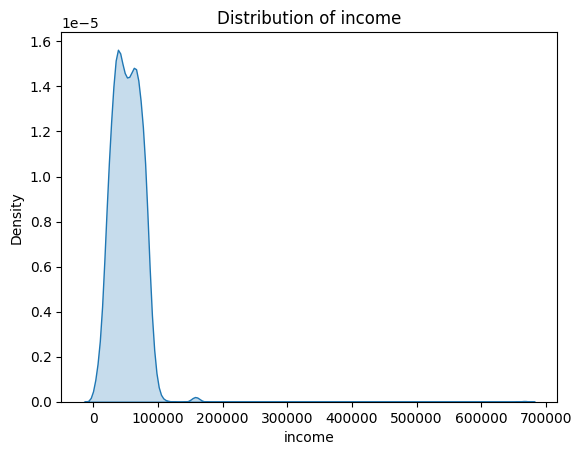

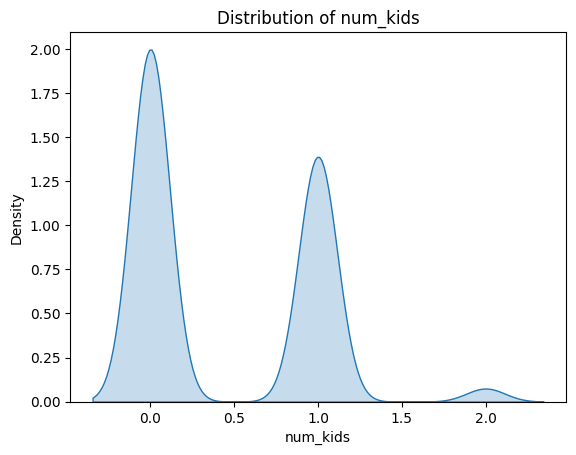

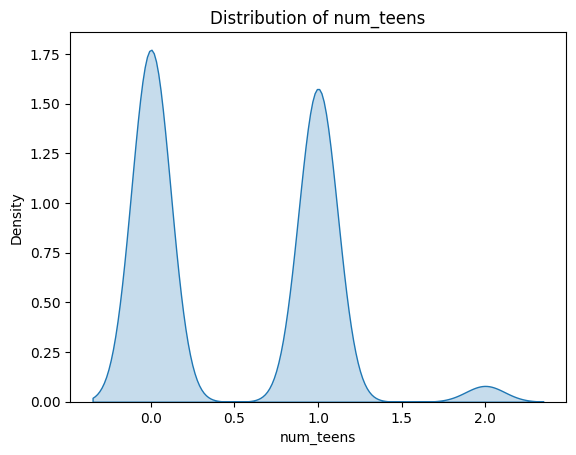

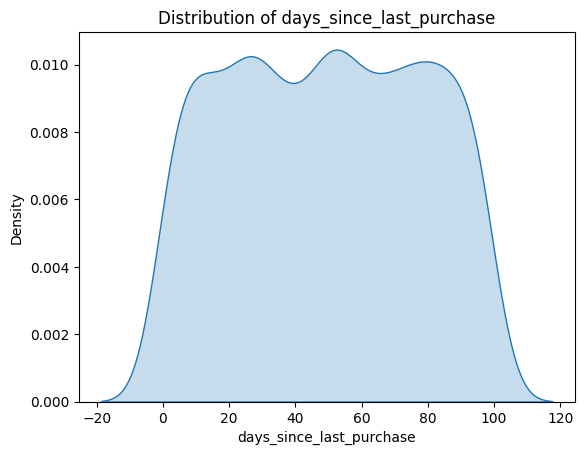

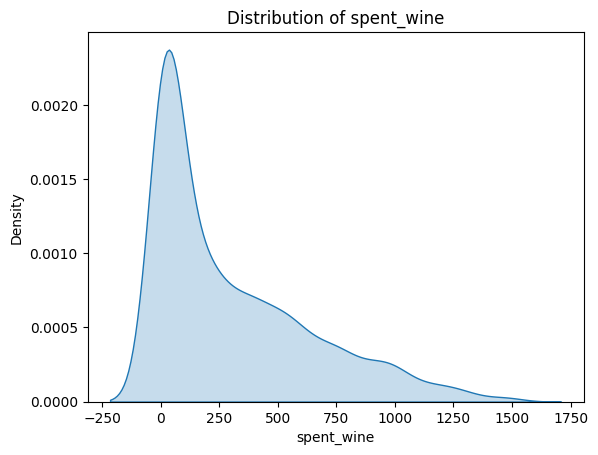

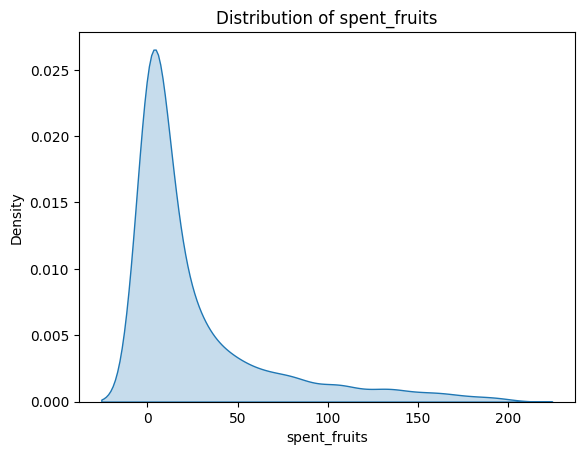

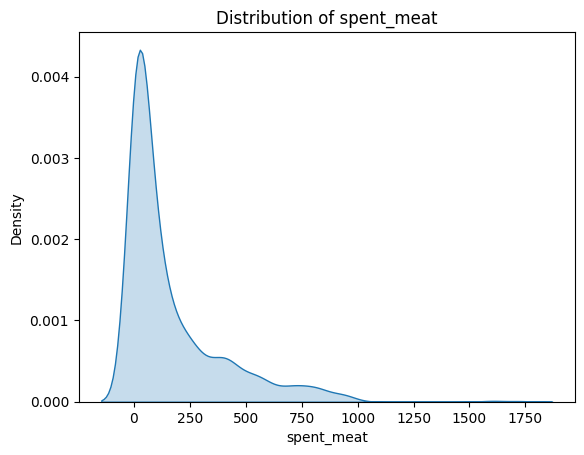

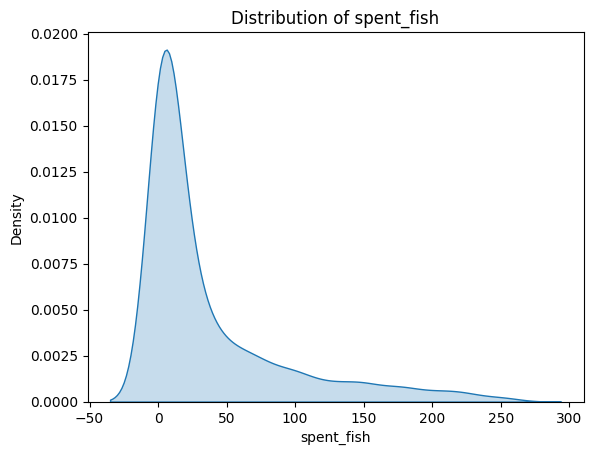

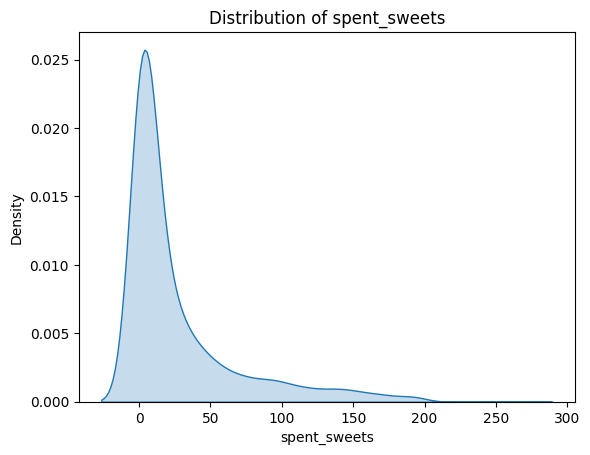

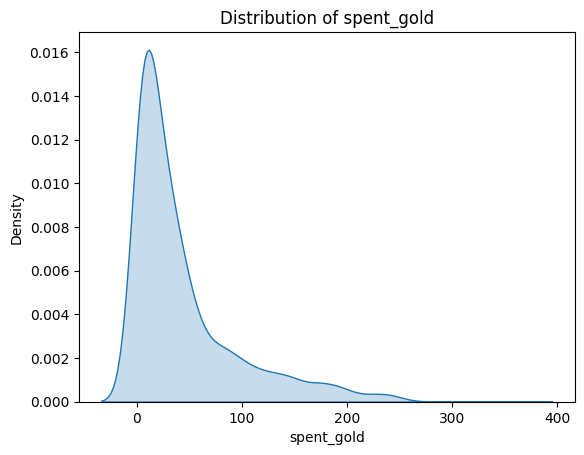

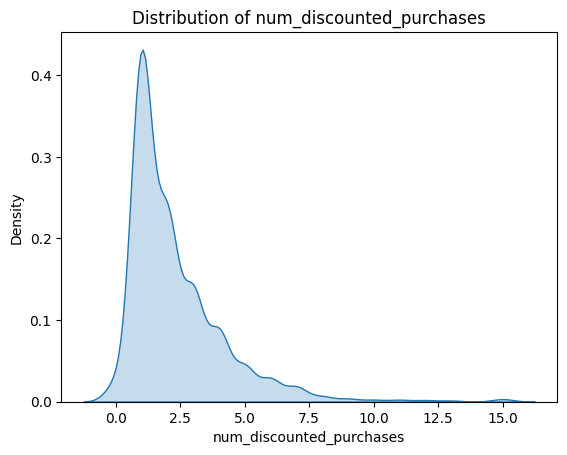

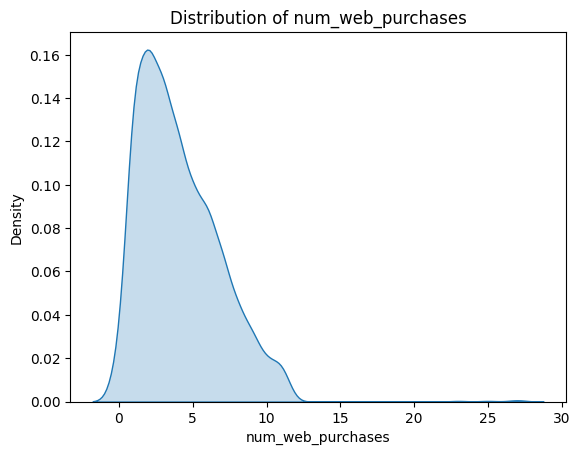

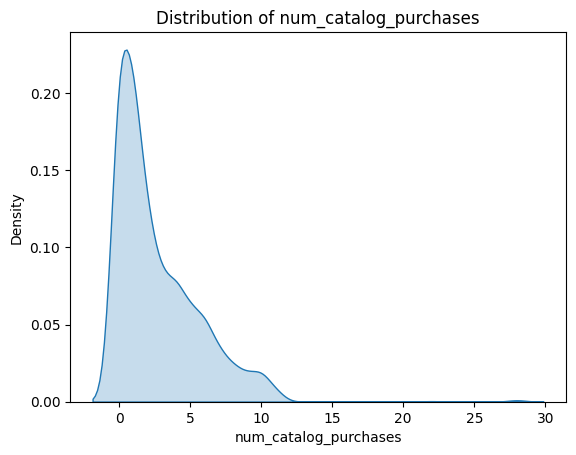

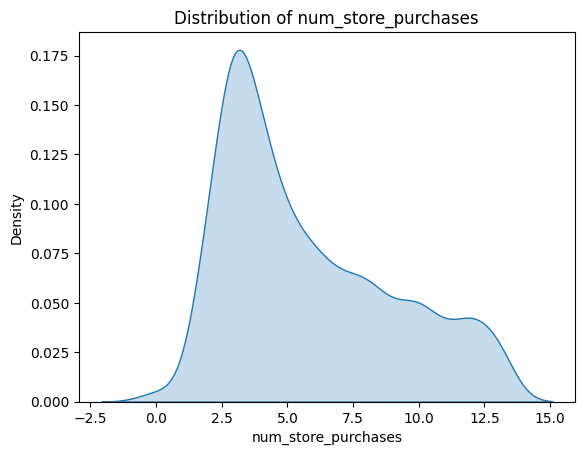

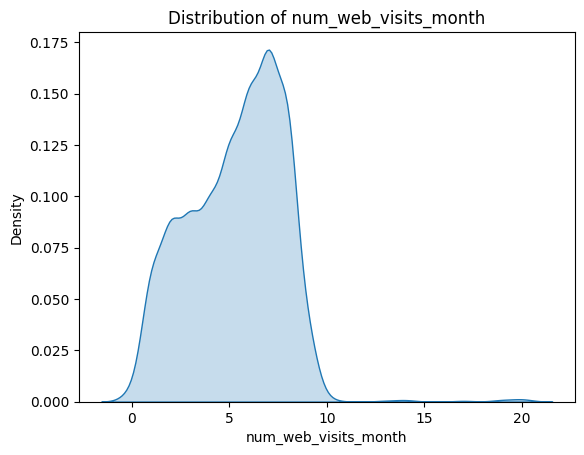

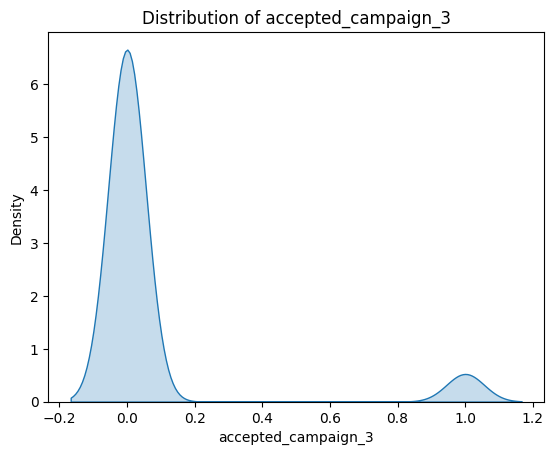

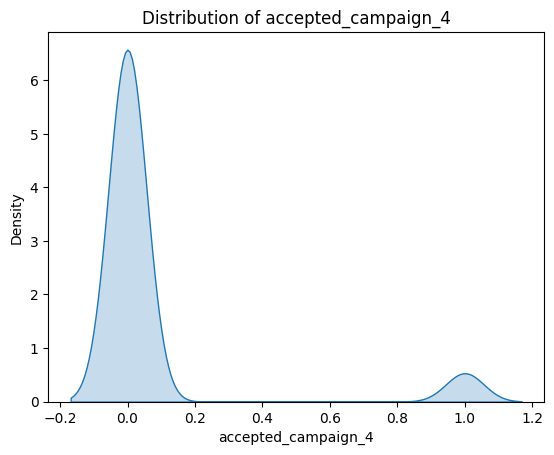

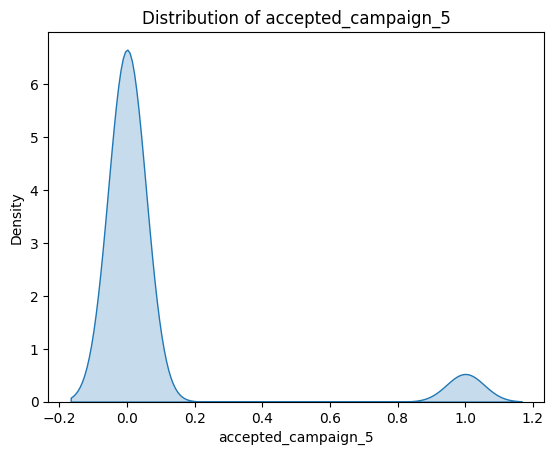

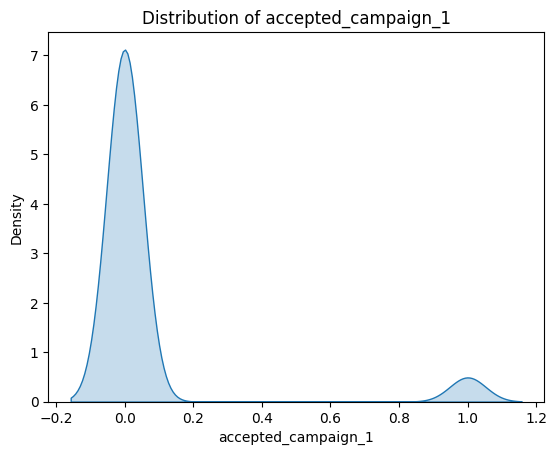

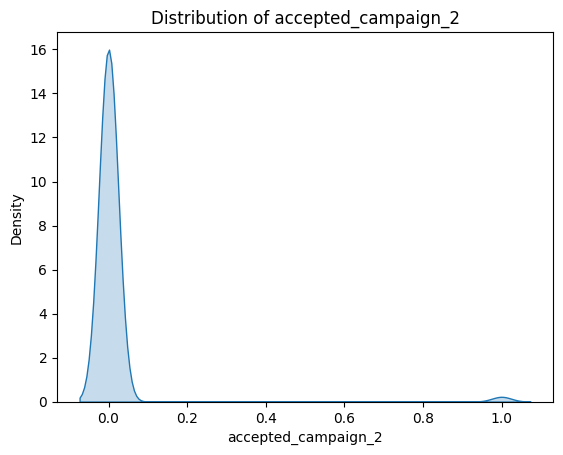

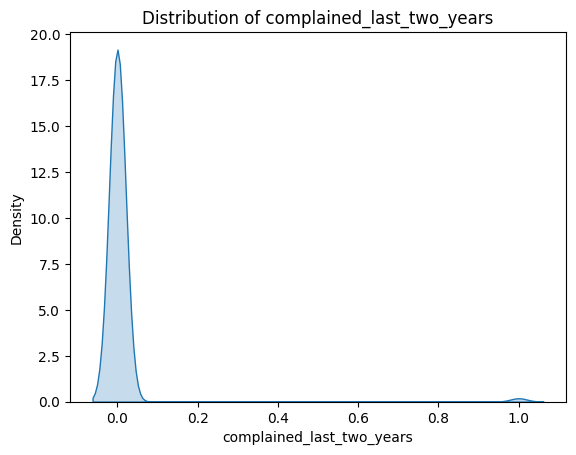

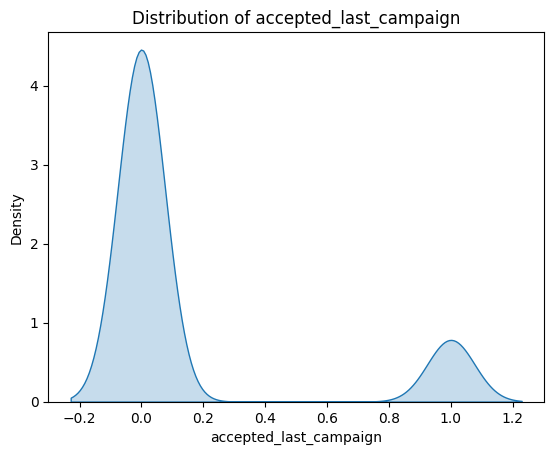

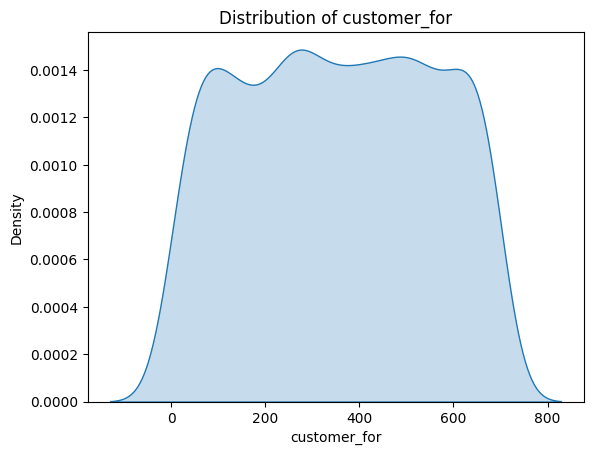

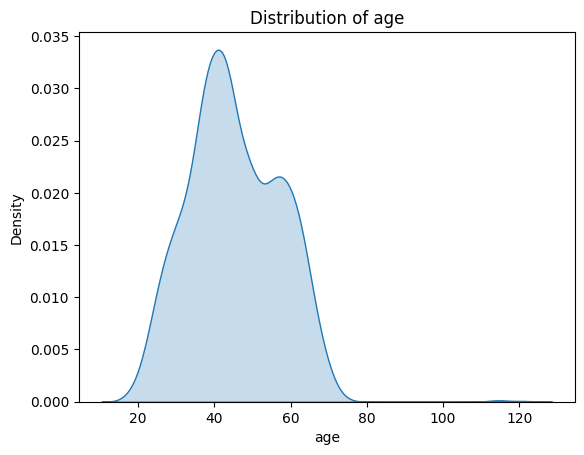

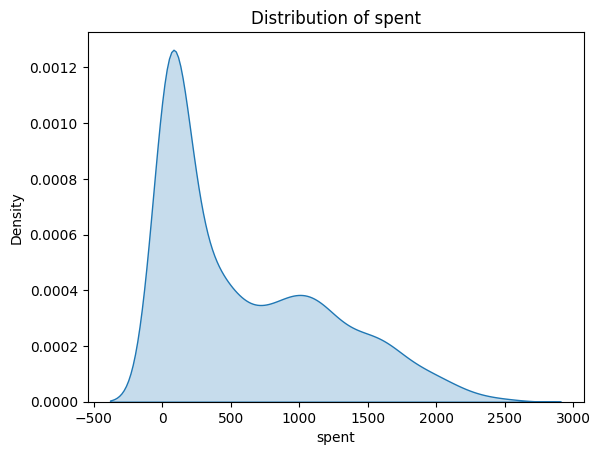

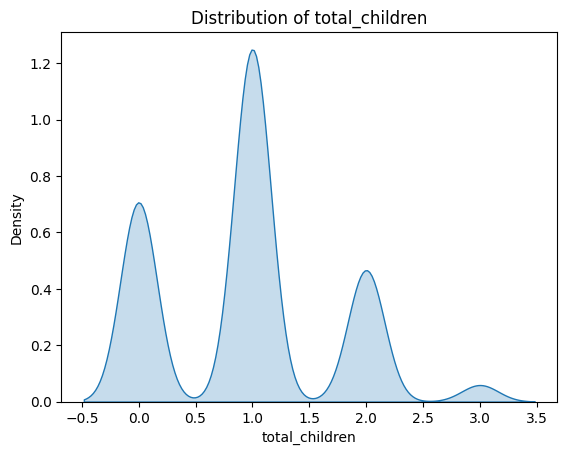

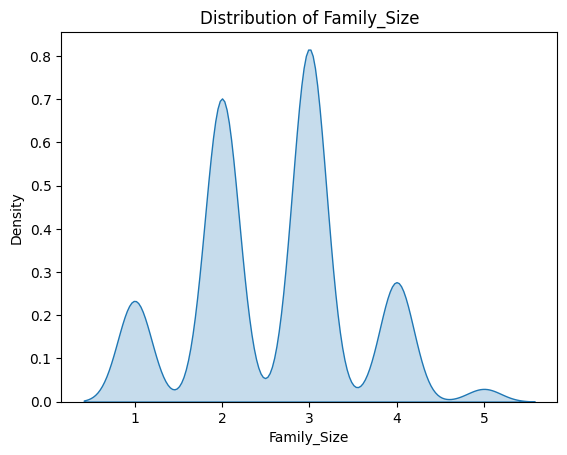

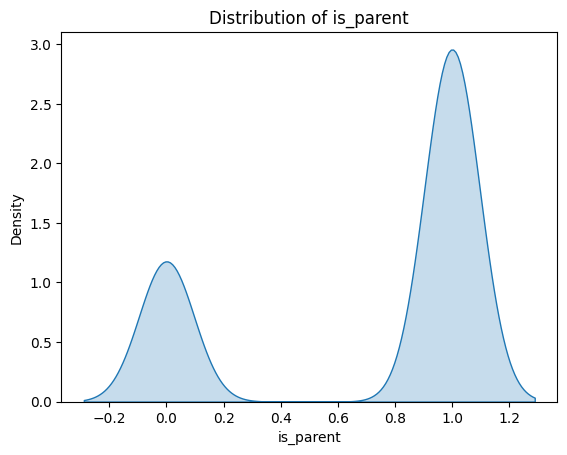

In [11]:
plot_distributions(df)

* At first glance, the distributions make sense
* But there appears to be some outliers in the Age category

In [12]:
# Checking for age outliers
df.select("age") \
  .filter(pl.col("age") > 85) \
  .sort(by = "age", descending=True)

age
i64
121
115
114


* We do indeed have outliers in the age column
* We will need to drop these columns

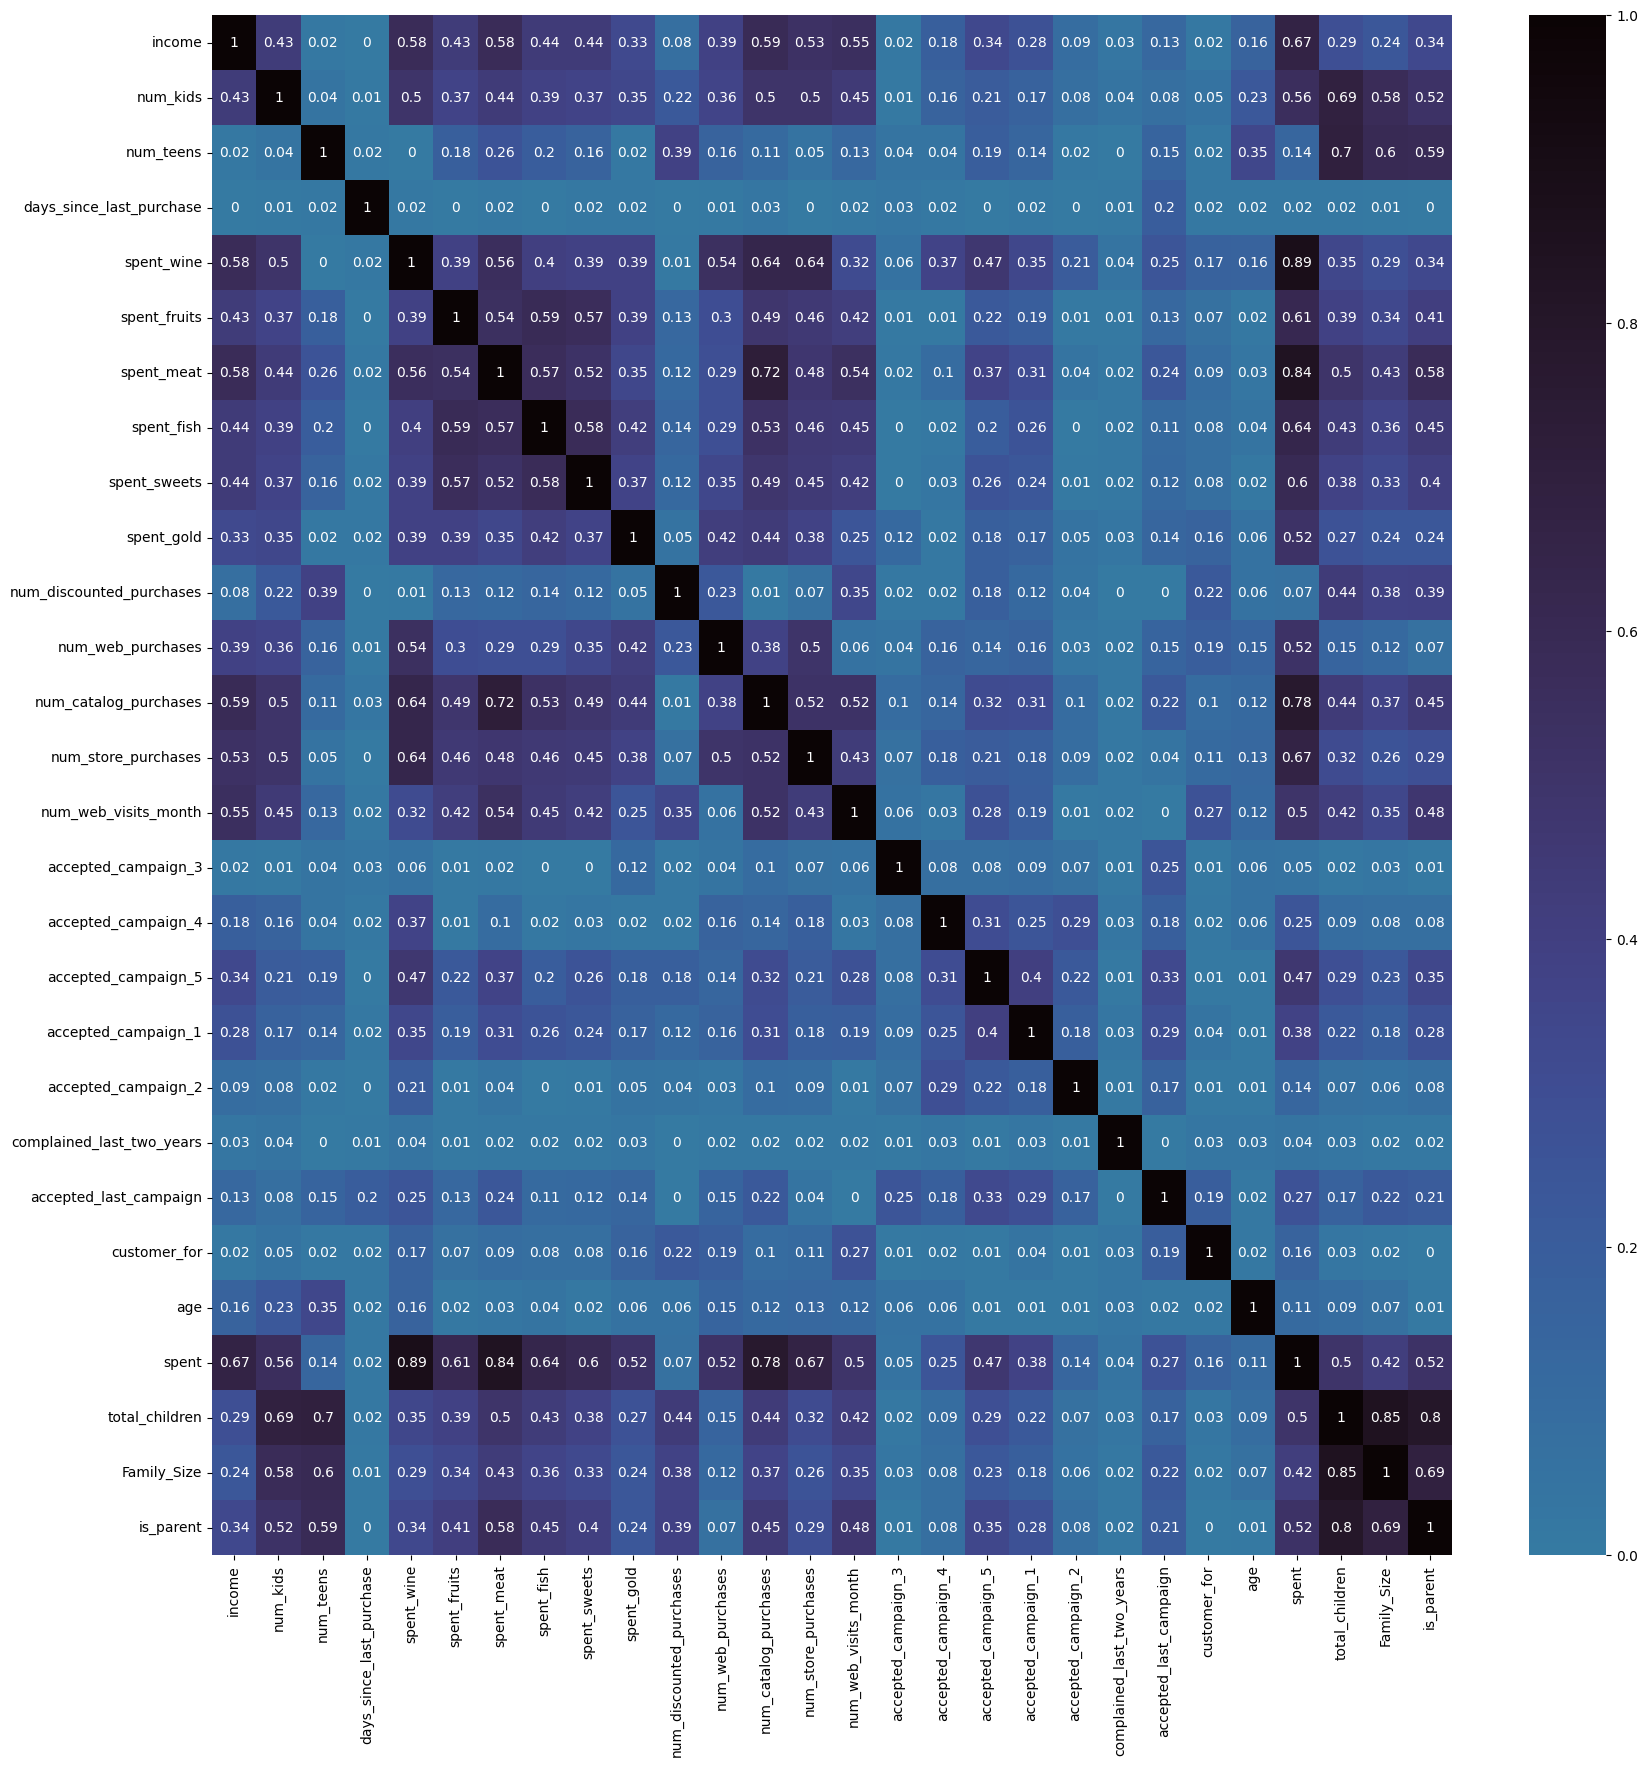

In [13]:
correlation_matrix(df);

# Data Processing and Dimensionality Reduction

In [14]:
def get_binary_columns(df):
    binary_columns_list = []
    for col_name in df.columns:
        distinct_values = df[col_name].unique().sort()
        if len(distinct_values) == 2 and distinct_values.to_list() == [0, 1]:
            binary_columns_list.append(col_name)
    return binary_columns_list


def scale_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    scaler = StandardScaler()
    # Convert to numpy for StandardScaler
    array_data = df.to_numpy()
    # Fit and transform
    scaled_array = scaler.fit_transform(array_data)
    # Create a new Polars DataFrame with the original column names
    scaled_df = pl.DataFrame(
        scaled_array,
        schema=df.columns
    )
    return scaled_df


def apply_pca(df: pl.DataFrame, n_components: int = 3) -> pl.DataFrame:
    pca = PCA(n_components=n_components)
    pca.fit(df.to_numpy())
    transformed = pca.transform(df.to_numpy())
    schema = [f"col{i+1}" for i in range(n_components)]
    return pl.DataFrame(transformed, schema=schema)

In [15]:
# Drop rows with nulls
df = df.drop_nulls()

In [16]:
# Remove age outliers we identified above
df = df.filter(pl.col("age") <= 100)

In [17]:
# Recode education column (higher education = 1, undergraduate = 0)
df = df.with_columns(
    pl.when(pl.col("education").is_in(["Postgraduate", "Graduate"])).then(1)
    .when(pl.col("education") == "Undergraduate").then(0)
    .otherwise(None)
    .alias("education")
)

# Recode living_with column (alone = 0, partner = 1)
df = df.with_columns(
    pl.when(pl.col("living_with") == "Alone").then(0)
    .when(pl.col("living_with") == "Partner").then(1)
    .otherwise(None)
    .alias("living_with")
)

In [18]:
# Create a copy of the df without boolean columns
# We should not scale our data or fit the clustering model
# using boolean features
df_numeric = df.clone().drop(get_binary_columns(df))

In [19]:
# Scale data and apply PCA
pca_df = apply_pca(scale_dataframe(df_numeric))

In [20]:
print("Data after scaling and PCA")
print(pca_df)

Data after scaling and PCA
shape: (2_213, 3)
┌───────────┬───────────┬───────────┐
│ col1      ┆ col2      ┆ col3      │
│ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╡
│ 4.712077  ┆ 0.061676  ┆ 2.115941  │
│ -2.883421 ┆ 0.229237  ┆ -2.064028 │
│ 2.233498  ┆ -0.684058 ┆ -0.073128 │
│ -2.571365 ┆ -1.641391 ┆ 0.083393  │
│ -0.506772 ┆ -0.086279 ┆ 0.327639  │
│ …         ┆ …         ┆ …         │
│ 2.614115  ┆ 1.943864  ┆ 0.662275  │
│ -2.949733 ┆ 4.236456  ┆ -1.366013 │
│ 2.246653  ┆ -1.611314 ┆ 0.191047  │
│ 1.723317  ┆ 1.24636   ┆ -1.786691 │
│ -2.605669 ┆ 1.810945  ┆ -0.101164 │
└───────────┴───────────┴───────────┘


In [21]:
# Visualizing our components
px.scatter_3d(pca_df, x="col1", y="col2", z="col3") \
    .update_traces(marker=dict(size=2)) \
    .show()

# Clustering

In [22]:
def elbow_plot(df: pl.DataFrame):
    inertias = []
    k_range = range(1, 11)
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=626, n_init='auto')
        model.fit(df)
        inertias.append(model.inertia_)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=list(k_range), y=inertias, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal k")
    plt.show()

def run_agglomerative_clustering(df, n_clusters=4):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(df)
    return cluster_labels

def add_cluster_column(df: pl.DataFrame, cluster_labels: np.ndarray) -> pl.DataFrame:
    df = df.with_columns(pl.Series("cluster", cluster_labels))
    return df

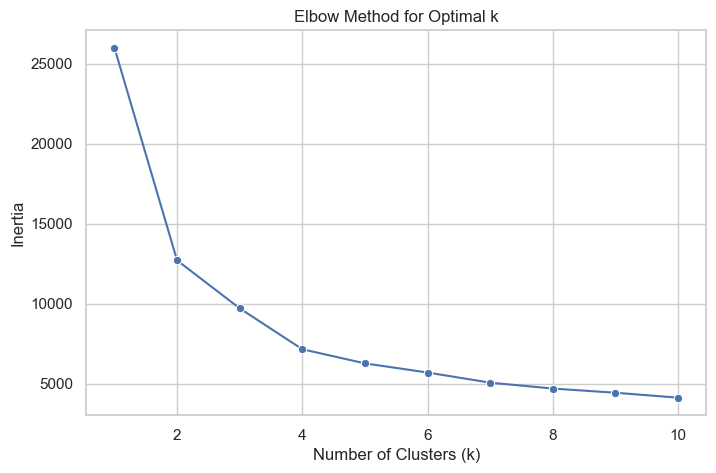

In [23]:
elbow_plot(pca_df)

* Based on the elbow plot above, the optimal number of clusters is 4

In [24]:
# Run the clustering model and store results
cluster_labels = run_agglomerative_clustering(pca_df)

In [25]:
# Append results to dataframes
pca_df = add_cluster_column(pca_df, cluster_labels)
df = add_cluster_column(df, cluster_labels)

In [26]:
print("Dataframe with clusters")
print(pca_df.head())

Dataframe with clusters
shape: (5, 4)
┌───────────┬───────────┬───────────┬─────────┐
│ col1      ┆ col2      ┆ col3      ┆ cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---     │
│ f64       ┆ f64       ┆ f64       ┆ i64     │
╞═══════════╪═══════════╪═══════════╪═════════╡
│ 4.712077  ┆ 0.061676  ┆ 2.115941  ┆ 2       │
│ -2.883421 ┆ 0.229237  ┆ -2.064028 ┆ 0       │
│ 2.233498  ┆ -0.684058 ┆ -0.073128 ┆ 2       │
│ -2.571365 ┆ -1.641391 ┆ 0.083393  ┆ 3       │
│ -0.506772 ┆ -0.086279 ┆ 0.327639  ┆ 1       │
└───────────┴───────────┴───────────┴─────────┘


# Analyze cluster results

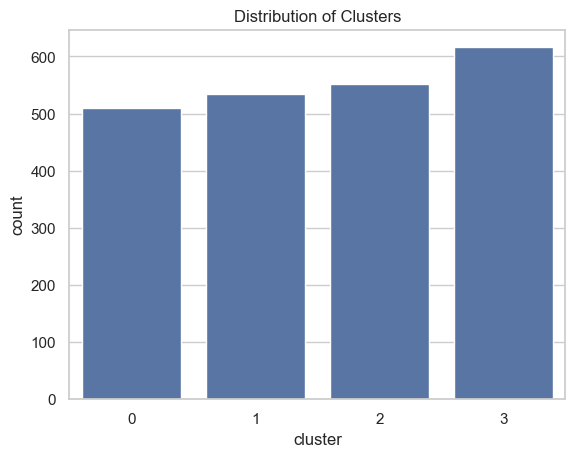

In [27]:
sns.countplot(df, x="cluster").set_title("Distribution of Clusters");

In [ ]:
custom_palette = ["purple", "yellow", "pink", "red"]

px.scatter(df, 
           x="income", 
           y="spent", 
           color="cluster",
           color_discrete_sequence=custom_palette,
           ) \
  .update_layout(legend_title_text='cluster',
                   coloraxis_colorbar=dict(tickvals=sorted(df['cluster'].unique()),
                                           ticktext=[str(i) for i in sorted(df['cluster'].unique())])
                   )


In [29]:
px.scatter(df, x="spent", y="income",
           facet_col="cluster",
           color_discrete_sequence=["black"],
).update_layout(yaxis_range=[0, 200000])

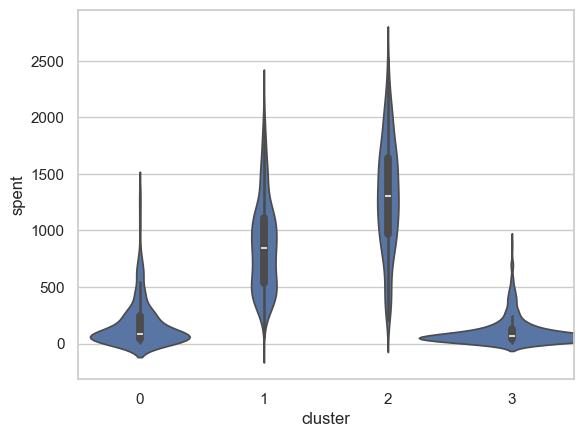

In [30]:
sns.violinplot(data=df, x="cluster", y="spent", width=1.5);

In [31]:
df \
    .select("cluster", "income", "spent") \
    .group_by("cluster") \
    .agg([
        pl.format("${}", pl.mean("income").round(2)).alias("mean_income"),
        pl.format("${}", pl.mean("spent").round(2)).alias("mean_spent")
        ])


cluster,mean_income,mean_spent
i64,str,str
0,"""$43784.77""","""$181.15"""
3,"""$30704.8""","""$109.43"""
1,"""$63280.38""","""$870.24"""
2,"""$73369.86""","""$1300.66"""


**Cluster 2:**
* Highest income
* Highest spending

**Cluster 0:**
* Low income
* Low spending

**Cluster 3:**
* Lowest income
* Lowest spending

**Cluster 1:**
* High income levels, but lower than Cluster 2
* High spend, but lower than Cluster 2

In [32]:
df

education,income,num_kids,num_teens,days_since_last_purchase,spent_wine,spent_fruits,spent_meat,spent_fish,spent_sweets,spent_gold,num_discounted_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_campaign_1,accepted_campaign_2,complained_last_two_years,accepted_last_campaign,customer_for,age,spent,living_with,total_children,Family_Size,is_parent,cluster
i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i64,i64,i32,i64
1,58138,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,663,57,1617,0,0,1,0,2
1,46344,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,113,60,27,0,2,3,1,0
1,71613,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,312,49,776,1,0,2,0,2
1,26646,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,139,30,53,1,1,3,1,3
1,58293,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,161,33,422,1,1,3,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,61223,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,381,47,1341,1,1,3,1,1
1,64014,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,19,68,444,1,3,5,1,0
1,56981,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,155,33,1241,0,0,1,0,2


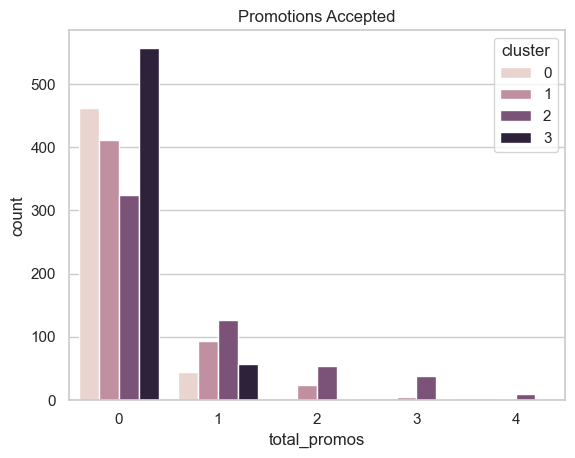

In [33]:
# Create a feature to get a sum of accepted promotions
df = df.with_columns(
    pl.sum_horizontal(["accepted_campaign_1", "accepted_campaign_2", "accepted_campaign_3", "accepted_campaign_4", "accepted_campaign_5"]).alias("total_promos")
    )

sns.countplot(data=df, x="total_promos", hue="cluster").set_title("Promotions Accepted");

* It seems that customer are not accepting promotions
* There is very little activity overall

In [34]:
df.glimpse()

Rows: 2213
Columns: 32
$ education                 <i32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ income                    <i64> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 33454, 30351, 5648
$ num_kids                  <i64> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1
$ num_teens                 <i64> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1
$ days_since_last_purchase  <i64> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68
$ spent_wine                <i64> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28
$ spent_fruits              <i64> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0
$ spent_meat                <i64> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6
$ spent_fish                <i64> 172, 2, 111, 10, 46, 0, 50, 3, 3, 1
$ spent_sweets              <i64> 88, 1, 21, 3, 27, 42, 49, 1, 3, 1
$ spent_gold                <i64> 88, 6, 42, 5, 15, 14, 27, 23, 2, 13
$ num_discounted_purchases  <i64> 3, 2, 1, 2, 5, 2, 4, 2, 1, 1
$ num_web_purchases         <i64> 8, 1, 8, 2, 5, 6, 7, 4, 3, 1
$ num_catalog_purchases     <i64> 10, 1, 2, 0, 3, 4, 3, 0

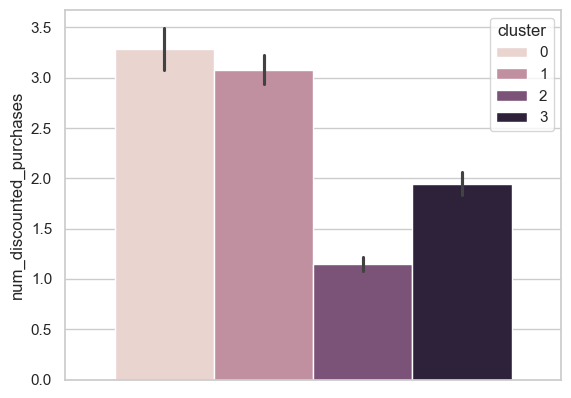

In [35]:
sns.barplot(data=df, y="num_discounted_purchases", hue="cluster");

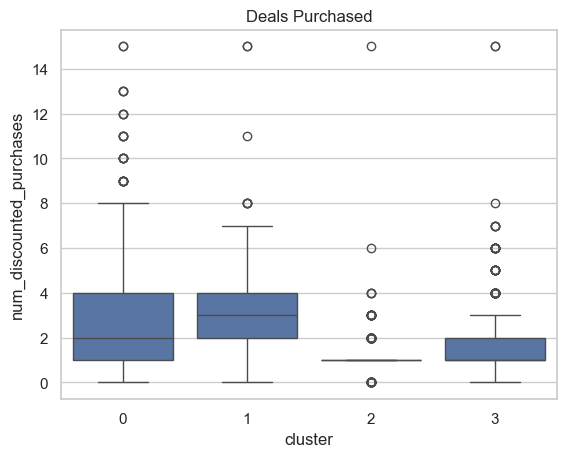

In [36]:
sns.boxplot(data=df, x="cluster", y="num_discounted_purchases").set_title("Deals Purchased");

In [37]:
df.group_by("cluster") \
    .agg(pl.sum("num_discounted_purchases")) \
    .sort("num_discounted_purchases", descending=True)

cluster,num_discounted_purchases
i64,i64
0,1677
1,1643
3,1195
2,631


* Deals perform better than promotions
* Cluster 2 (highest income and spending) purchases the least amount of deals
* Clusters 0 (low income, low spending) and Cluster 1 (moderately high income and spend) purchase the most number of deals

* It appears that Cluster 1 represents savvy shoppers
